In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [ ]:
df=pd.read_csv('online_course_engagement_data.csv')

df.head()


,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,1,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,0,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,0,0


In [ ]:
df=df.drop('UserID',axis=1)


In [132]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CourseCategory         9000 non-null   object 
 1   TimeSpentOnCourse      9000 non-null   float64
 2   NumberOfVideosWatched  9000 non-null   int64  
 3   NumberOfQuizzesTaken   9000 non-null   int64  
 4   QuizScores             9000 non-null   float64
 5   CompletionRate         9000 non-null   float64
 6   DeviceType             9000 non-null   int64  
 7   CourseCompletion       9000 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 562.6+ KB


# Identify The Problem : => Classification Problem 

In [ ]:
df.head()


,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,Health,29.979719,17,3,50.365656,20.860773,1,0
1,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,Science,35.038427,17,10,59.198853,95.433162,0,1
4,Programming,92.490647,16,0,98.428285,18.102478,0,0


# Feature Analysis

### Structural understanding

In [ ]:
df.columns


Index(['CourseCategory', 'TimeSpentOnCourse', 'NumberOfVideosWatched',
       'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'DeviceType',
       'CourseCompletion'],
      dtype='object')

In [ ]:
df.dtypes


CourseCategory            object
TimeSpentOnCourse        float64
NumberOfVideosWatched      int64
NumberOfQuizzesTaken       int64
QuizScores               float64
CompletionRate           float64
DeviceType                 int64
CourseCompletion           int64
dtype: object

### Data quality checks

In [ ]:
df.isnull().sum()


CourseCategory           0
TimeSpentOnCourse        0
NumberOfVideosWatched    0
NumberOfQuizzesTaken     0
QuizScores               0
CompletionRate           0
DeviceType               0
CourseCompletion         0
dtype: int64

In [ ]:
df.duplicated().sum()


np.int64(877)

In [ ]:
df.shape


(9000, 8)

### Distribution & variability analysis

In [139]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
TimeSpentOnCourse,9000.0,50.163822,28.491750,1.005230,25.440548,49.818417,75.069924,99.992558
NumberOfVideosWatched,9000.0,10.024667,6.029878,0.000000,5.000000,10.000000,15.000000,20.000000
NumberOfQuizzesTaken,9000.0,5.090556,3.157762,0.000000,2.000000,5.000000,8.000000,10.000000
QuizScores,9000.0,74.706028,14.378383,50.005119,62.283451,74.743294,87.022663,99.994984
CompletionRate,9000.0,50.340146,28.950977,0.009327,25.653614,50.264124,75.572493,99.979711
DeviceType,9000.0,0.500667,0.500027,0.000000,0.000000,1.000000,1.000000,1.000000
CourseCompletion,9000.0,0.396444,0.489186,0.000000,0.000000,0.000000,1.000000,1.000000


### Skewed Checking

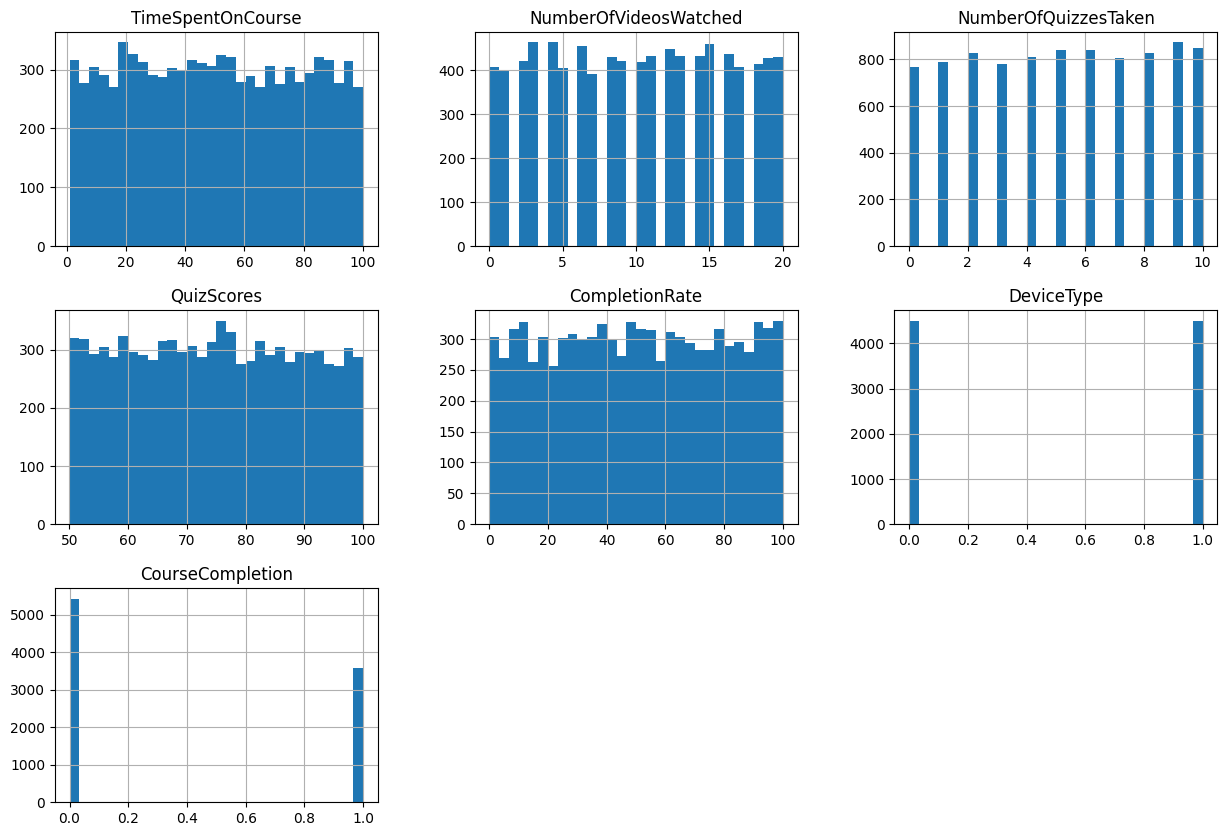

In [ ]:
import matplotlib.pyplot as plt

df.select_dtypes(include="number").hist(
    figsize=(15, 10),
    bins=30
)
plt.show()


In [141]:
df['CourseCategory'].value_counts()



CourseCategory
Business       1837
Health         1821
Science        1814
Programming    1810
Arts           1718
Name: count, dtype: int64

In [ ]:
df['DeviceType'].value_counts()


DeviceType
1    4506
0    4494
Name: count, dtype: int64

In [ ]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object", "bool"]).columns


In [ ]:
df[num_cols].skew().sort_values(ascending=False)


CourseCompletion         0.423473
QuizScores               0.020827
TimeSpentOnCourse        0.019218
NumberOfVideosWatched   -0.001909
CompletionRate          -0.002339
DeviceType              -0.002667
NumberOfQuizzesTaken    -0.031117
dtype: float64

### Outliers

In [ ]:
num_cols = df.select_dtypes(include="number").columns

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(col, "outliers:", outliers.shape[0])


TimeSpentOnCourse outliers: 0
NumberOfVideosWatched outliers: 0
NumberOfQuizzesTaken outliers: 0
QuizScores outliers: 0
CompletionRate outliers: 0
DeviceType outliers: 0
CourseCompletion outliers: 0


### Imbalancy Checking

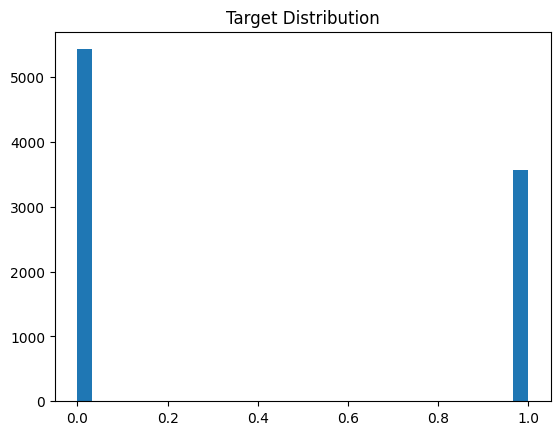

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df["CourseCompletion"], bins=30)
plt.title("Target Distribution")
plt.show()


In [ ]:
for col in num_cols:
    print(f"\n{col}")
    print(f"Maximum {df[col].max()},Minimum {df[col].min()}")



TimeSpentOnCourse
Maximum 99.99255785648448,Minimum 1.005229866297383

NumberOfVideosWatched
Maximum 20,Minimum 0

NumberOfQuizzesTaken
Maximum 10,Minimum 0

QuizScores
Maximum 99.99498421511456,Minimum 50.005118626292344

CompletionRate
Maximum 99.97971128119624,Minimum 0.0093268021242876

DeviceType
Maximum 1,Minimum 0

CourseCompletion
Maximum 1,Minimum 0


In [ ]:
for col in num_cols:
    print(col, df[col].nunique())


TimeSpentOnCourse 8123
NumberOfVideosWatched 21
NumberOfQuizzesTaken 11
QuizScores 8123
CompletionRate 8123
DeviceType 2
CourseCompletion 2


### Checking Data Imbalancy

In [ ]:
for col in cat_cols:
    print(f"\n{col}")
    print(df[col].value_counts())



CourseCategory
CourseCategory
Business       1837
Health         1821
Science        1814
Programming    1810
Arts           1718
Name: count, dtype: int64


### Correlation check based on target column

In [ ]:
df[num_cols].corr()["CourseCompletion"].sort_values(ascending=False)


CourseCompletion         1.000000
CompletionRate           0.326139
QuizScores               0.299983
NumberOfQuizzesTaken     0.284504
NumberOfVideosWatched    0.234360
TimeSpentOnCourse        0.182553
DeviceType               0.007551
Name: CourseCompletion, dtype: float64

<Axes: ylabel='Density'>

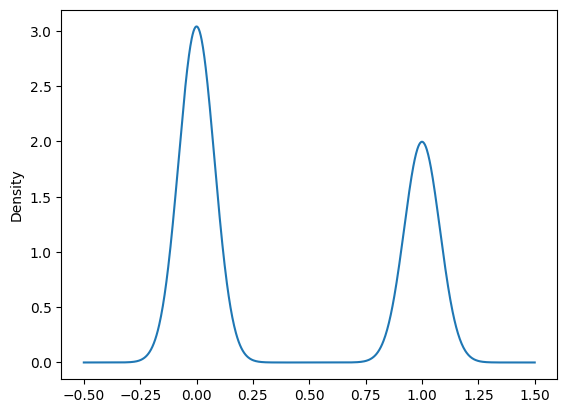

In [ ]:
df['CourseCompletion'].plot(kind='density') 


# Feature Enginnering

In [ ]:
X = df.drop(columns=["CourseCompletion"])
y = df["CourseCompletion"]


In [ ]:
y.skew()


np.float64(0.4234732639936478)

In [ ]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "bool"]).columns


In [ ]:
df['CourseCategory'].unique()


array(['Health', 'Arts', 'Science', 'Programming', 'Business'],
      dtype=object)

In [ ]:
cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


In [ ]:
num_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ],
    remainder="drop"
)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,     
    test_size=0.2,
    random_state=42
)


In [160]:
from sklearn.linear_model import LogisticRegression


log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        solver='lbfgs'
    ))
])


In [ ]:
log_reg_model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred = log_reg_model.predict(X_test)


In [163]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7916666666666666
Precision: 0.7644444444444445
Recall: 0.7049180327868853
F1 Score: 0.7334754797441365

Confusion Matrix:
 [[909 159]
 [216 516]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      1068
           1       0.76      0.70      0.73       732

    accuracy                           0.79      1800
   macro avg       0.79      0.78      0.78      1800
weighted avg       0.79      0.79      0.79      1800



In [172]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg_model, X, y, cv=5, scoring='accuracy')
print(scores)
print("Mean Accuracy:", scores.mean())


[0.79222222 0.79555556 0.79944444 0.81055556 0.79666667]
Mean Accuracy: 0.7988888888888889


In [166]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,     
        max_depth=None,         
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1           
    ))
])


In [167]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


In [168]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1068
           1       0.95      0.92      0.94       732

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800

[[1036   32]
 [  56  676]]


In [171]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(scores)
print("Mean Accuracy:", scores.mean())


[0.95       0.95444444 0.96       0.96555556 0.96777778]
Mean Accuracy: 0.9595555555555556


In [170]:
df[['CompletionRate', 'CourseCompletion']].corr()


,CompletionRate,CourseCompletion
CompletionRate,1.000000,0.326139
CourseCompletion,0.326139,1.000000


In [173]:
import pandas as pd

rf_model.fit(X, y)

importances = rf_model.named_steps['model'].feature_importances_
features = rf_model.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))


                            Feature  Importance
4               num__CompletionRate    0.238481
3                   num__QuizScores    0.227654
2         num__NumberOfQuizzesTaken    0.185905
1        num__NumberOfVideosWatched    0.178770
0            num__TimeSpentOnCourse    0.152358
5                   num__DeviceType    0.004406
10      cat__CourseCategory_Science    0.002599
7      cat__CourseCategory_Business    0.002555
9   cat__CourseCategory_Programming    0.002518
6          cat__CourseCategory_Arts    0.002452
